# Stock Price Prediction

## Importing the libraries

In [1]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from yahoo_fin import stock_info as si
import datetime as dt
from pyspark.ml import Pipeline
import pandas_datareader as pdr
from pyspark.ml.regression import GBTRegressor
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, dayofmonth, concat, lpad, monotonically_increasing_id
from pyspark.ml.regression import RandomForestRegressor
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd

## Data Collection

In [2]:
ticker = 'TSLA'
start_date = dt.datetime(2013, 9, 30)
end_date = dt.datetime.now()
fred_symbols = ['SP500', 'DJIA', 'NASDAQCOM', 'VIXCLS', 'GVZCLS', 'DTWEXBGS', 'IUDSOIA', 'BAMLHE00EHYIEY', 'DFF', 'T10Y2Y', 'DGS10', 'T10YIE', 'T5YIE', 'DTB3']
historical_data = si.get_data(ticker, start_date, end_date, interval='1d')
fred_df = pdr.get_data_fred(fred_symbols, start_date, end_date)

# Data Pre-Processing with Spark

In [3]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .config("spark.driver.maxResultSize", "512m") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "512m") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 10:57:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
historical_data_spark = spark.createDataFrame(historical_data.reset_index())
fred_df_spark = spark.createDataFrame(fred_df.reset_index())
historical_data_spark = historical_data_spark.withColumnRenamed("index", "DATE")
historical_data_spark = historical_data_spark.drop('ticker', 'adjclose')

historical_data_spark = historical_data_spark.withColumn("year", year("DATE"))
historical_data_spark = historical_data_spark.withColumn("month", month("DATE"))
historical_data_spark = historical_data_spark.withColumn("day", dayofmonth("DATE"))
historical_data_spark = historical_data_spark.withColumn('fulldate', concat(historical_data_spark['year'],
                                                                            lpad(historical_data_spark['month'], 2,
                                                                                 '0'),
                                                                            lpad(historical_data_spark['day'], 2, '0')))
historical_data_spark = historical_data_spark.withColumn('fulldate', historical_data_spark['fulldate'].cast('int'))
fred_df_spark = fred_df_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = historical_data_spark.join(fred_df_spark, on="DATE", how="left")
dataset_spark = dataset_spark.orderBy("DATE")
dataset_spark = dataset_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = dataset_spark.dropna()

# Save into an array the DATE column
dates = dataset_spark.select("DATE").collect()
# Dates to convert into pandas array
dates = [date[0] for date in dates]
dataset_spark_training = dataset_spark.drop("DATE")
# Save into an array the close column
all_closes = dataset_spark.select("close").collect()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=18369Kb max_used=18369Kb free=112702Kb
 bounds [0x00000001029a0000, 0x0000000103bb0000, 0x000000010a9a0000]
 total_blobs=7640 nmethods=6800 adapters=753
 compilation: disabled (not enough contiguous free space left)


## Data Explaration

+-----------------+-----------------+----------------+------------------+
|        min_close|        max_close|      mean_close|      stddev_close|
+-----------------+-----------------+----------------+------------------+
|8.033332824707031|409.9700012207031|88.0854024567748|106.31051280128389|
+-----------------+-----------------+----------------+------------------+


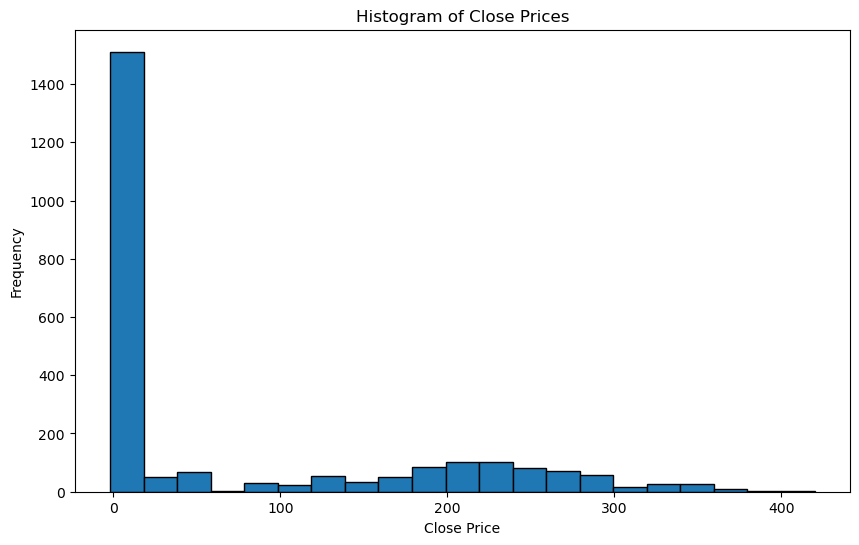

In [5]:
# Use Spark SQL to get some basic statistics and print the results
dataset_spark.createOrReplaceTempView("dataset_spark")

# Calculate summary statistics for the "close" column
summary_query = "SELECT MIN(close) AS min_close, MAX(close) AS max_close, AVG(close) AS mean_close, STDDEV(close) AS stddev_close FROM dataset_spark"
summary_result = spark.sql(summary_query)
summary_result.show()

# Define the number of bins for the histogram
num_bins = 20

# Calculate bin width
bin_width = (summary_result.collect()[0]["max_close"] - summary_result.collect()[0]["min_close"]) / num_bins

# Generate the histogram data
histogram_query = f"SELECT CAST((close - {summary_result.collect()[0]['min_close']}) / {bin_width} AS INT) AS bin, COUNT(*) AS frequency FROM dataset_spark GROUP BY bin ORDER BY bin"
histogram_data = spark.sql(histogram_query)

# Collect the histogram data to the driver
histogram_data_df = histogram_data.toPandas()

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(histogram_data_df["bin"] * bin_width + summary_result.collect()[0]["min_close"], histogram_data_df["frequency"], width=bin_width, edgecolor='k')
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.title("Histogram of Close Prices")
plt.show()

# MLLib

In [6]:
# Prepare data for MLlib
feature_columns = [col_name for col_name in dataset_spark_training.columns if col_name != 'close']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# Determine the split point based on the desired ratio
split_ratio = 0.8  # 80% for training, 20% for testing
split_point = int(dataset_spark_training.count() * split_ratio)

# Split the data into training and testing sets
train_data = dataset_spark_training.limit(split_point)
test_data = dataset_spark_training.subtract(train_data)

# Reorder by index
train_data = train_data.orderBy("Index")
test_data = test_data.orderBy("Index")

## Linear Regression

In [7]:
lr = LinearRegression(labelCol='close', featuresCol='features')
lr_pipeline = Pipeline(stages=[vector_assembler, lr])
# Linear Regression in Spark
lr_model = lr_pipeline.fit(train_data)
# Model Evaluation in Spark
lr_predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

# Convert lr_predictions DataFrame to Pandas DataFrame
lr_predictions_pd = lr_predictions.select("Index", "close", "prediction").toPandas()

# Extract the actual "close" values and timestamp
actual_close = lr_predictions_pd["close"]

# Extract the predicted values
lr_predicted_close = lr_predictions_pd["prediction"]

# Take just last 20% of dates (the testing set)
dates_test = dates[split_point:]

23/10/10 10:57:41 WARN Instrumentation: [78b4c192] regParam is zero, which might cause numerical instability and overfitting.
23/10/10 10:57:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/10 10:57:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


## Random Forest

In [8]:
# Create a Random Forest Regressor model
rf = RandomForestRegressor(labelCol='close', featuresCol='features', numTrees=3)
rf_pipeline = Pipeline(stages=[vector_assembler, rf])
# Fit the Random Forest Regressor model
rf_model = rf_pipeline.fit(train_data)
# Model Evaluation in Spark
# Make predictions using the Random Forest Regressor model
rf_predictions = rf_model.transform(test_data)
# Evaluate the Random Forest Regressor model
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)

rf_predictions_pd = rf_predictions.select("Index", "close", "prediction").toPandas()
# Extract the predicted values
rf_predicted_close = rf_predictions_pd["prediction"]

## Gradient Boosted Tree

In [9]:
# Create a Random Forest Regressor model
gbt = GBTRegressor(labelCol='close', featuresCol='features')
gbt_pipeline = Pipeline(stages=[vector_assembler, gbt])
# Fit the Random Forest Regressor model
gbt_model = gbt_pipeline.fit(train_data)
# Model Evaluation in Spark
# Make predictions using the Random Forest Regressor model
gbt_predictions = gbt_model.transform(test_data)
# Evaluate the Random Forest Regressor model
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
gbt_rmse = evaluator.evaluate(gbt_predictions)

gbt_predictions_pd = gbt_predictions.select("Index", "close", "prediction").toPandas()
# Extract the predicted values
gbt_predicted_close = gbt_predictions_pd["prediction"]

# Plot the results

Linear Regression RMSE: 3.812
Random Forest RMSE: 108.762
Gradient Boosted Tree RMSE: 50.452


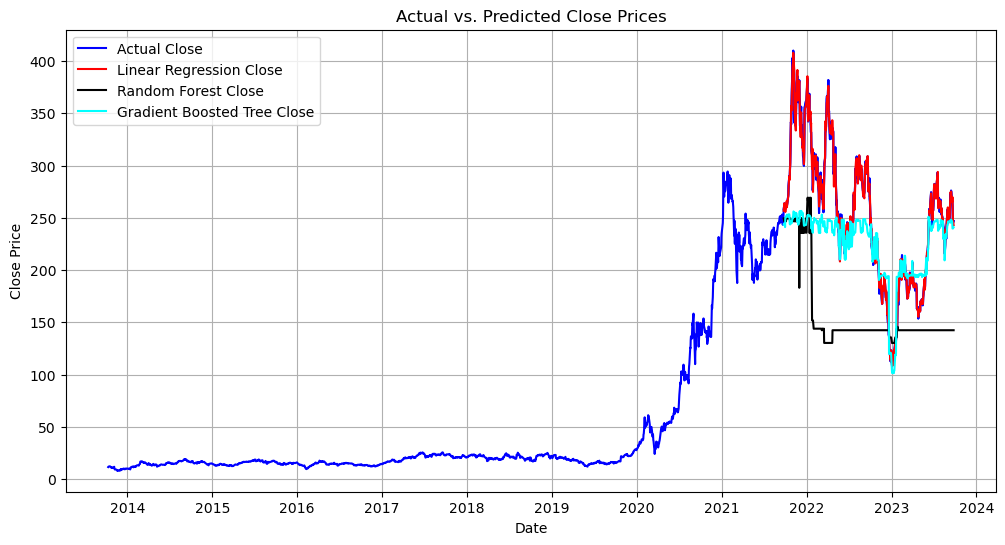

In [10]:
# Print the RMSE for each model
print("Linear Regression RMSE: %.3f" % lr_rmse)
print("Random Forest RMSE: %.3f" % rf_rmse)
print("Gradient Boosted Tree RMSE: %.3f" % gbt_rmse)


# Create a time series plot also with all training data
plt.figure(figsize=(12, 6))
plt.plot(dates, all_closes, color="b")
plt.plot(dates_test, actual_close, label="Actual Close", color="b")
plt.plot(dates_test, lr_predicted_close, label="Linear Regression Close", color="r")
plt.plot(dates_test, rf_predicted_close, label="Random Forest Close", color="k")
plt.plot(dates_test, gbt_predicted_close, label="Gradient Boosted Tree Close", color="aqua")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()

# Explaining the results

## Feature Importance


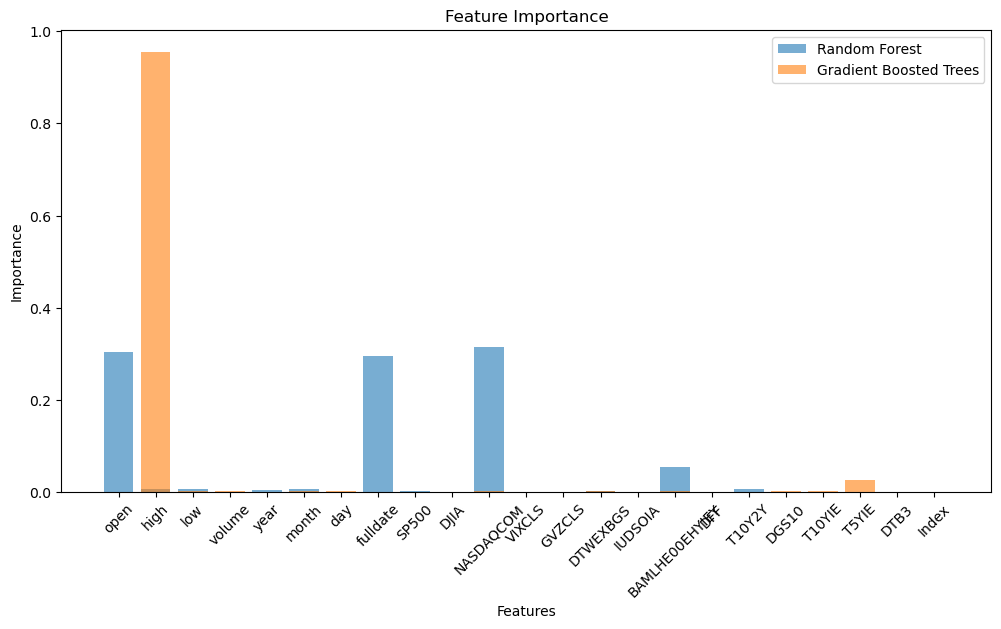

In [11]:
# For Random Forest
rf_importance = rf_model.stages[-1].featureImportances.toArray()

# For Gradient Boosted Trees
gbt_importance = gbt_model.stages[-1].featureImportances.toArray()

# Plotting feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_columns, rf_importance, label="Random Forest", alpha=0.6)
plt.bar(feature_columns, gbt_importance, label="Gradient Boosted Trees", alpha=0.6)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.legend()
plt.xticks(rotation=45)
plt.show()

## XAI - Lime

In [12]:
train_data_pd = train_data.toPandas()
X_train = train_data_pd.drop(['close'], axis=1)
y_train = train_data_pd[['close']]
test_data_pd = test_data.toPandas()
X_test = test_data_pd.drop(['close'], axis=1)
y_test = test_data_pd[['close']]

In [13]:
explainer = LimeTabularExplainer(X_train.values, 
                                 mode="regression",
                                 feature_names=X_train.columns.tolist(),
                                 training_labels=y_train,
                                 verbose=True)

In [14]:
instance = X_test.iloc[0].values

In [18]:
# For the Linear Regression model
print("Explanation for Linear Regression")
lr_prediction_func = lambda x: lr_model.transform(spark.createDataFrame(pd.DataFrame(x, columns=X_test.columns))).select("prediction").toPandas().values
lr_exp = explainer.explain_instance(instance, lr_prediction_func)
lr_exp.show_in_notebook()

Explanation for Linear Regression
Intercept 17.787514702414434
Prediction_local [151.83607453]
Right: 256.8060745930343


In [16]:
# For the Random Forest model
print("Explanation for Random Forest")
rf_prediction_func = lambda x: rf_model.transform(spark.createDataFrame(pd.DataFrame(x, columns=X_test.columns))).select("prediction").toPandas().values
rf_exp = explainer.explain_instance(instance, rf_prediction_func)
rf_exp.show_in_notebook()


Explanation for Random Forest
Intercept 14.91482541164288
Prediction_local [154.0394174]
Right: 249.43641270963076


In [17]:
# For the Gradient Boosted Tree model
print("Explanation for Gradient Boosted Tree")
gbt_prediction_func = lambda x: gbt_model.transform(spark.createDataFrame(pd.DataFrame(x, columns=X_test.columns))).select("prediction").toPandas().values
gbt_exp = explainer.explain_instance(instance, gbt_prediction_func)
gbt_exp.show_in_notebook()

Explanation for Gradient Boosted Tree
Intercept 14.148833622928102
Prediction_local [150.84301969]
Right: 243.52636636959252
